In [36]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

#download the dataset from https://www.kaggle.com/datasets/spandan2/cats-faces-64x64-for-generative-models
#place the extracted folder into the cat_faces and your ready to go(the final path: ./cat_faces/cats/)

In [37]:
dir = './cat_faces/'
print(os.listdir(dir))

['cats']


In [38]:
print(os.listdir(dir+'/cats')[:20])

['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '10000.jpg', '10001.jpg', '10002.jpg', '10003.jpg', '10004.jpg', '10005.jpg', '10006.jpg', '10007.jpg', '10008.jpg', '10009.jpg', '1001.jpg', '10010.jpg', '10011.jpg', '10012.jpg', '10013.jpg', '10014.jpg']


In [39]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(dir, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3)

In [40]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [41]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

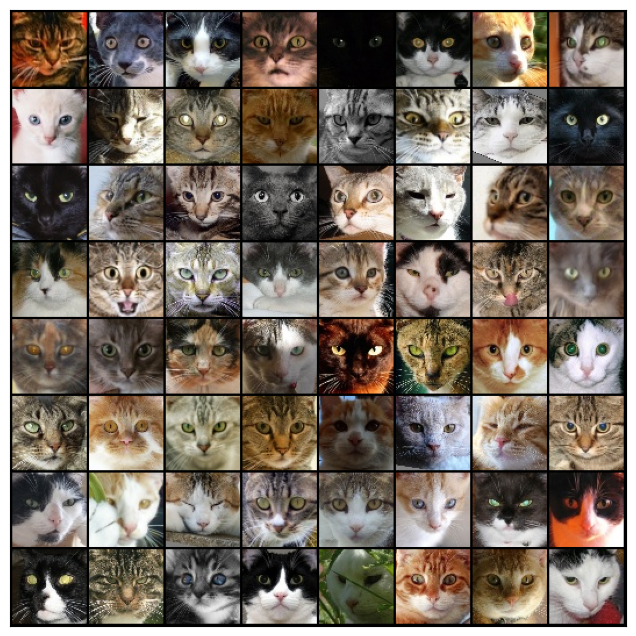

In [42]:
show_batch(train_dl)

In [43]:
def is_cuda_available():
    if torch.cuda.is_available():
        print("Cuda is available")
        return torch.device("cuda")
    else:
        print("cuda is'nt available")
        return torch.device("cpu")  

In [44]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [45]:
device = is_cuda_available()
train_dl = DeviceDataLoader(train_dl,device)

Cuda is available


In [46]:
#basic cnn with convolutional layers and leaky relu as activation fn
discriminator = nn.Sequential(
    # in: 3 x 64 x 64
    nn.Conv2d(3 , 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    # out: 64 x 32 x 32
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    #out: 128 x 16 x 16
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    #out: 256 x 8 x 8
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    #out: 512 x 4 x 4
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    #Out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())


In [47]:
discriminator = to_device(discriminator, device)

In [48]:
latent_size = 128 #size of the noise vector
generator = nn.Sequential(
    #in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64,kernel_size =4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    #out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


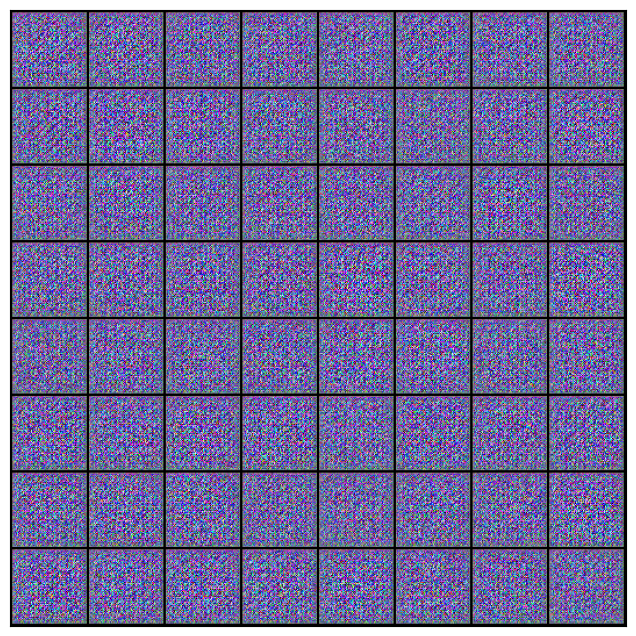

In [49]:
xb = torch.randn(batch_size, latent_size,1,1)   #latent_size = is the size of the noise vector #batch_size = number of images
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [50]:
generator = to_device(generator, device)


In [63]:
def train_discriminator(real_images, opt_d):  #opt_d = optimizer for discriminator
    #clear discriminator gradients
    opt_d.zero_grad()

    #pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [64]:
def train_generator(opt_g):
    opt_g.zero_grad()

    #generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    #try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size,1,device = device)
    loss = F.binary_cross_entropy(preds, targets)


    #update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [65]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [66]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [67]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


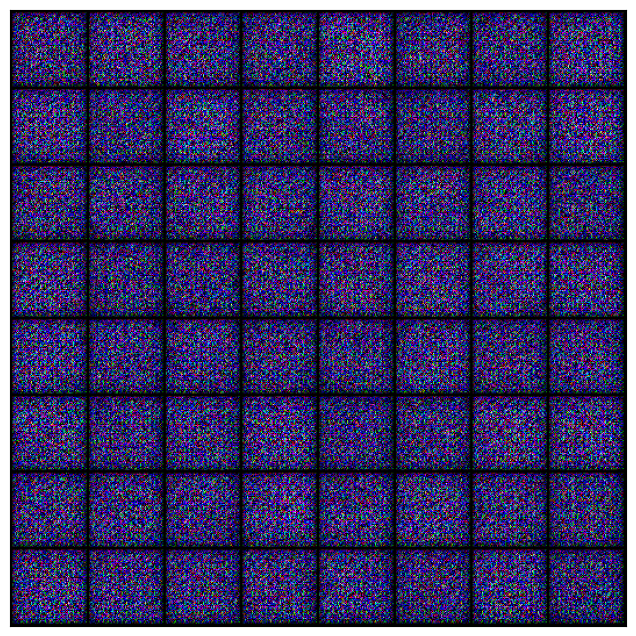

In [68]:
save_samples(0, fixed_latent)

In [69]:
def fit(epochs,lr,start_idx =1):  #lr = learning rate, start_idx = starting index
    torch.cuda.empty_cache()

    #losses and scores
    losses_g = []   #losses for generator supposed to decrease
    losses_d = []   #losses for discriminator supposed to increase
    real_scores = []   #how well the discriminator scores the real images
    fake_scores = []   #how well the discriminator scores the fake images

    #create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr = lr, betas=(0.5,0.999))    #betas = parameters for the optimizer
    opt_g = torch.optim.Adam(generator.parameters(), lr = lr, betas=(0.5,0.999))


    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [70]:
lr = 0.0003
epochs = 60


In [71]:
history=fit(epochs,lr)

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1/60], loss_g: 2.9541, loss_d: 1.6019, real_score: 0.2897, fake_score: 0.0401
Saving generated-images-0001.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/60], loss_g: 3.1393, loss_d: 0.8137, real_score: 0.7399, fake_score: 0.3610
Saving generated-images-0002.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/60], loss_g: 1.2651, loss_d: 1.1264, real_score: 0.5766, fake_score: 0.3653
Saving generated-images-0003.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/60], loss_g: 4.5311, loss_d: 0.8068, real_score: 0.8253, fake_score: 0.4109
Saving generated-images-0004.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/60], loss_g: 4.4665, loss_d: 0.4553, real_score: 0.8912, fake_score: 0.2589
Saving generated-images-0005.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/60], loss_g: 4.4430, loss_d: 0.5321, real_score: 0.7528, fake_score: 0.1066
Saving generated-images-0006.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/60], loss_g: 1.3143, loss_d: 2.4489, real_score: 0.1952, fake_score: 0.1308
Saving generated-images-0007.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/60], loss_g: 4.9623, loss_d: 0.3644, real_score: 0.9059, fake_score: 0.2180
Saving generated-images-0008.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/60], loss_g: 1.6444, loss_d: 2.0091, real_score: 0.2434, fake_score: 0.0198
Saving generated-images-0009.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/60], loss_g: 2.6447, loss_d: 0.6123, real_score: 0.6344, fake_score: 0.1281
Saving generated-images-0010.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [11/60], loss_g: 1.7234, loss_d: 1.0407, real_score: 0.5005, fake_score: 0.1085
Saving generated-images-0011.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [12/60], loss_g: 1.8261, loss_d: 0.5933, real_score: 0.6827, fake_score: 0.1647
Saving generated-images-0012.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [13/60], loss_g: 2.7879, loss_d: 0.4484, real_score: 0.8165, fake_score: 0.1881
Saving generated-images-0013.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [14/60], loss_g: 0.7915, loss_d: 1.4385, real_score: 0.2550, fake_score: 0.0618
Saving generated-images-0014.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [15/60], loss_g: 5.0817, loss_d: 0.1209, real_score: 0.9511, fake_score: 0.0653
Saving generated-images-0015.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [16/60], loss_g: 4.2775, loss_d: 0.2731, real_score: 0.9222, fake_score: 0.1667
Saving generated-images-0016.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [17/60], loss_g: 7.4266, loss_d: 0.7093, real_score: 0.9134, fake_score: 0.4195
Saving generated-images-0017.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [18/60], loss_g: 8.5468, loss_d: 0.7598, real_score: 0.9826, fake_score: 0.4805
Saving generated-images-0018.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [19/60], loss_g: 7.6437, loss_d: 0.1579, real_score: 0.8651, fake_score: 0.0055
Saving generated-images-0019.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [20/60], loss_g: 5.2223, loss_d: 1.1765, real_score: 0.3237, fake_score: 0.0005
Saving generated-images-0020.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [21/60], loss_g: 5.2713, loss_d: 0.1313, real_score: 0.8915, fake_score: 0.0040
Saving generated-images-0021.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [22/60], loss_g: 5.7022, loss_d: 0.0218, real_score: 0.9950, fake_score: 0.0165
Saving generated-images-0022.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [23/60], loss_g: 4.1327, loss_d: 0.1038, real_score: 0.9506, fake_score: 0.0480
Saving generated-images-0023.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [24/60], loss_g: 3.4631, loss_d: 0.0686, real_score: 0.9856, fake_score: 0.0505
Saving generated-images-0024.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [25/60], loss_g: 5.5820, loss_d: 0.0947, real_score: 0.9796, fake_score: 0.0654
Saving generated-images-0025.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [26/60], loss_g: 4.5643, loss_d: 0.6293, real_score: 0.7581, fake_score: 0.2586
Saving generated-images-0026.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [27/60], loss_g: 4.2892, loss_d: 0.1976, real_score: 0.8960, fake_score: 0.0684
Saving generated-images-0027.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [28/60], loss_g: 6.0798, loss_d: 0.2674, real_score: 0.9303, fake_score: 0.1677
Saving generated-images-0028.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [29/60], loss_g: 1.6696, loss_d: 0.5518, real_score: 0.6219, fake_score: 0.0403
Saving generated-images-0029.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [30/60], loss_g: 4.4944, loss_d: 0.0560, real_score: 0.9977, fake_score: 0.0506
Saving generated-images-0030.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [31/60], loss_g: 6.5934, loss_d: 0.2286, real_score: 0.9945, fake_score: 0.1826
Saving generated-images-0031.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [32/60], loss_g: 4.6827, loss_d: 0.1203, real_score: 0.9960, fake_score: 0.1050
Saving generated-images-0032.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [33/60], loss_g: 5.4604, loss_d: 0.0975, real_score: 0.9877, fake_score: 0.0772
Saving generated-images-0033.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [34/60], loss_g: 3.5152, loss_d: 0.3590, real_score: 0.7327, fake_score: 0.0318
Saving generated-images-0034.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [35/60], loss_g: 4.0232, loss_d: 0.1893, real_score: 0.8972, fake_score: 0.0718
Saving generated-images-0035.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [36/60], loss_g: 4.5364, loss_d: 0.0894, real_score: 0.9833, fake_score: 0.0677
Saving generated-images-0036.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [37/60], loss_g: 7.8108, loss_d: 0.1257, real_score: 0.8855, fake_score: 0.0007
Saving generated-images-0037.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [38/60], loss_g: 6.5353, loss_d: 0.3083, real_score: 0.9983, fake_score: 0.2199
Saving generated-images-0038.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [39/60], loss_g: 0.1536, loss_d: 3.9772, real_score: 0.0210, fake_score: 0.0125
Saving generated-images-0039.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [40/60], loss_g: 5.3368, loss_d: 0.0309, real_score: 0.9864, fake_score: 0.0167
Saving generated-images-0040.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [41/60], loss_g: 1.0724, loss_d: 0.7784, real_score: 0.5546, fake_score: 0.0232
Saving generated-images-0041.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [42/60], loss_g: 3.7535, loss_d: 0.0201, real_score: 0.9930, fake_score: 0.0128
Saving generated-images-0042.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [43/60], loss_g: 5.6203, loss_d: 0.0279, real_score: 0.9980, fake_score: 0.0251
Saving generated-images-0043.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [44/60], loss_g: 5.0677, loss_d: 0.2093, real_score: 0.9071, fake_score: 0.0746
Saving generated-images-0044.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [45/60], loss_g: 5.8828, loss_d: 0.3686, real_score: 0.8998, fake_score: 0.2003
Saving generated-images-0045.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [46/60], loss_g: 4.6605, loss_d: 0.5704, real_score: 0.8003, fake_score: 0.2243
Saving generated-images-0046.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [47/60], loss_g: 3.7999, loss_d: 3.8521, real_score: 0.0696, fake_score: 0.0002
Saving generated-images-0047.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [48/60], loss_g: 0.1840, loss_d: 2.6800, real_score: 0.2685, fake_score: 0.0614
Saving generated-images-0048.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [49/60], loss_g: 0.6309, loss_d: 0.6436, real_score: 0.5814, fake_score: 0.0396
Saving generated-images-0049.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [50/60], loss_g: 8.2203, loss_d: 0.4718, real_score: 0.9630, fake_score: 0.2977
Saving generated-images-0050.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [51/60], loss_g: 1.4972, loss_d: 0.8592, real_score: 0.4819, fake_score: 0.0100
Saving generated-images-0051.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [52/60], loss_g: 1.0389, loss_d: 0.9733, real_score: 0.5243, fake_score: 0.0114
Saving generated-images-0052.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [53/60], loss_g: 6.0882, loss_d: 0.4058, real_score: 0.9844, fake_score: 0.2862
Saving generated-images-0053.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [54/60], loss_g: 8.8074, loss_d: 0.0483, real_score: 0.9546, fake_score: 0.0005
Saving generated-images-0054.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [55/60], loss_g: 5.6608, loss_d: 0.0391, real_score: 0.9707, fake_score: 0.0090
Saving generated-images-0055.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [56/60], loss_g: 3.1217, loss_d: 0.8138, real_score: 0.6508, fake_score: 0.0472
Saving generated-images-0056.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [57/60], loss_g: 5.7891, loss_d: 0.2416, real_score: 0.9960, fake_score: 0.1873
Saving generated-images-0057.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [58/60], loss_g: 1.1675, loss_d: 0.5688, real_score: 0.6757, fake_score: 0.1050
Saving generated-images-0058.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [59/60], loss_g: 3.7248, loss_d: 0.0430, real_score: 0.9914, fake_score: 0.0329
Saving generated-images-0059.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [60/60], loss_g: 10.1984, loss_d: 1.3669, real_score: 0.9948, fake_score: 0.6419
Saving generated-images-0060.png


In [72]:
losses_g, losses_d, real_scores, fake_scores = history

In [73]:
from IPython.display import Image


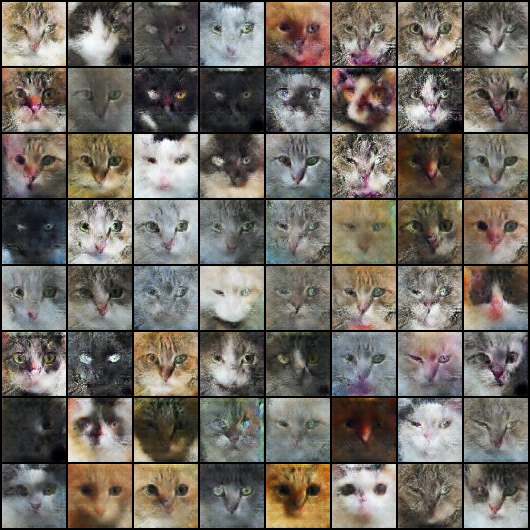

In [74]:
Image('./generated/generated-images-0033.png')

In [75]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

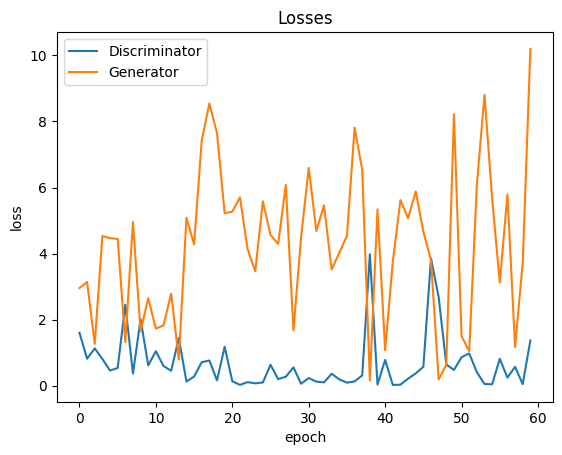

In [76]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

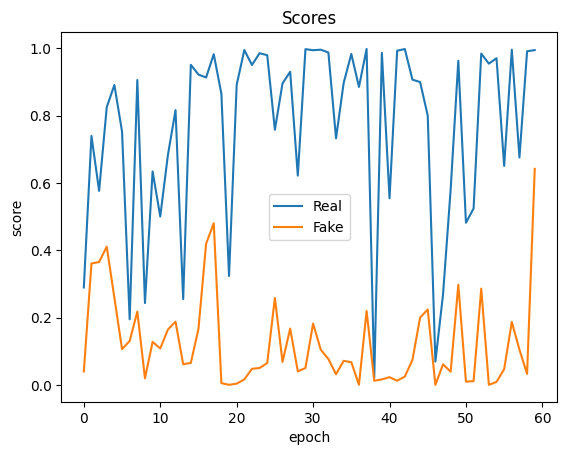

In [77]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


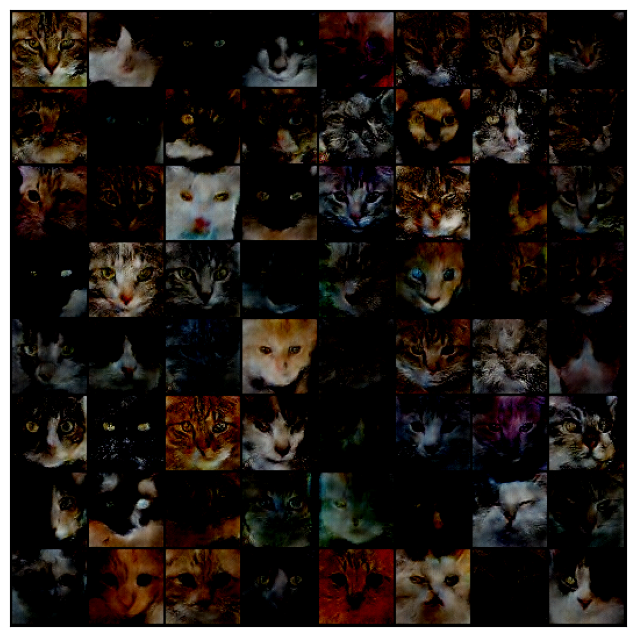

In [78]:
save_samples(0, fixed_latent) # 0 is the starting index of the images fixed_latent is the noise vector

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 64, 64])


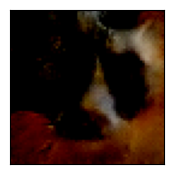

In [123]:
#generate fake images
latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
fake_images = generator(latent)
print(fake_images.shape)
fig, ax = plt.subplots(figsize=(2,2))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(fake_images[0].cpu().detach()).permute(1, 2, 0))  #permute = rearrange the dimensions of the tensor